# Dynamical systems modeling in Julia 2022 

- This notebook builds upon the previous dynamical systems modeling tutorial in #julialang from [here](https://github.com/adamlmaclean/julia-dynsys-resources/blob/main/Dynsys-ecomodel.ipynb)
- Where before we focused on `Catalyst.jl`, here we demo `ModelingToolkit.jl` as a symbolic-numerical modeling environment with great flexibility and potential 
- We also dip into `DiffEqFlux.jl`
- See [https://mtk.sciml.ai/](https://mtk.sciml.ai/) for much more!

Set up the environment (all code run on v1.7.3)


NB there's repitition of `using Pkg` in code blocks below to reiterate which packages are used where 

In [1]:
using ModelingToolkit
using Catalyst, Latexify, DifferentialEquations
using Plots, Makie, CairoMakie
using GlobalSensitivity
using NonlinearSolve
using Statistics, Random


Previously, we used `Catalyst` to introduce the model 🐬 $\xrightarrow{\textrm{eat}}$ 🐸 $\xrightarrow{\textrm{eat}}$ 🐜  as: 


In [2]:
using Catalyst
ecomodel = @reaction_network begin
    α₁*(1 - 0.01*🐜 - 0.05*🐸), 🐜 --> 2🐜
    α₂*(1 - 0.1*🐬), 🐜 --> 🐸
    δ₁, 🐜 --> ∅
    δ₂, 🐸 --> 🐬
    δ₃, 🐬 --> ∅
    end α₁ α₂ δ₁ δ₂ δ₃


Model ##ReactionSystem#291
States (3):
  🐜(t)
  🐸(t)
  🐬(t)
Parameters (5):
  α₁
  α₂
  δ₁
  δ₂
  δ₃

From the definition of the model as a reaction network, we can turn it into various realizations of a dynamical system, e.g. a system of ODEs (through assumption of mass action kinetics) or a discrete-time stochastic process that can be simulated via Gillespie's algorithm. 👇

In [3]:
odes = convert(ODESystem, ecomodel)
latexify(odes)

L"\begin{align}
\frac{d🐜(t)}{dt} =&  - \delta_1 🐜\left( t \right) + \alpha_1 \left( 1 - 0.01 🐜\left( t \right) - 0.05 🐸\left( t \right) \right) 🐜\left( t \right) - \alpha_2 \left( 1 - 0.1 🐬\left( t \right) \right) 🐜\left( t \right) \\
\frac{d🐸(t)}{dt} =& \alpha_2 \left( 1 - 0.1 🐬\left( t \right) \right) 🐜\left( t \right) - \delta_2 🐸\left( t \right) \\
\frac{d🐬(t)}{dt} =& \delta_2 🐸\left( t \right) - \delta_3 🐬\left( t \right)
\end{align}
"

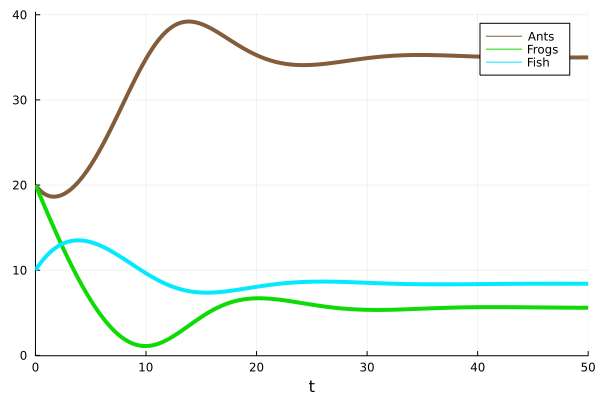

In [4]:
## Colors for plotting
cc = ["#835C3B" "#10DA05" "#05E9FF"]

## Parameters [α₁ α₂ δ₁ δ₂ δ₃]
pp = (0.2, 0.15, 0.05, 0.15, 0.1)

## Initial conditions
u₀ = [20., 20., 10.]

## time span for simulation 
tspan = (0., 50.)

## create the ODE system
ds = ODEProblem(ecomodel, u₀, tspan, pp)

sol = solve(ds, Tsit5())
Plots.plot(sol, lw=4, lc=cc, labels=["Ants" "Frogs" "Fish"])

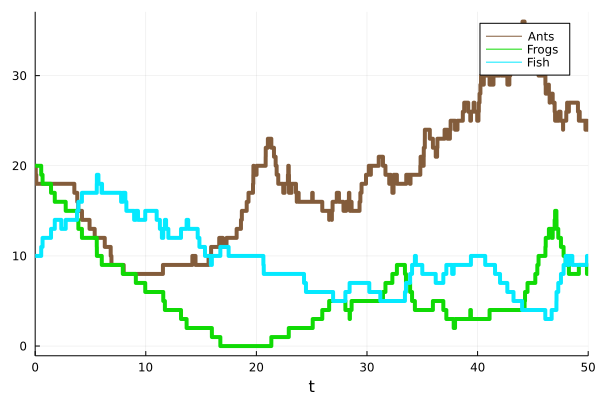

In [5]:
ds_discrete = DiscreteProblem(ecomodel, [20,20,10], tspan, pp)
jump_ds = JumpProblem(ecomodel, ds_discrete, Direct())

sol = solve(jump_ds, SSAStepper())
Plots.plot(sol, lw=4, lc=cc, labels=["Ants" "Frogs" "Fish"])


## Dynamical systems modeling with MTK

Now let's redefine the model using `ModelingToolkit (MTK)`. For straightforward simulation or model analyses, this is more or less equivalent to that above using `Catalyst`, but `MTK` packs a lot more under the hood as we'll see...


In [11]:
using ModelingToolkit
@parameters t α₁ α₂ δ₁ δ₂ δ₃ g₁ g₂ g₃
@variables 🐜(t) 🐸(t) 🐬(t)
D = Differential(t)

eco_eqs = [D(🐜) ~ α₁*🐜*(1 - g₁*🐜 - g₂*🐸) - α₂*🐜*(1-0.1*🐬) - δ₁*🐜,
           D(🐸) ~ α₂*🐜*(1 - g₃*🐬) - δ₂*🐸,
           D(🐬) ~ δ₂*🐸 - δ₃*🐬]


3-element Vector{Equation}:
 Differential(t)(🐜(t)) ~ α₁*(1 - g₁*🐜(t) - g₂*🐸(t))*🐜(t) - δ₁*🐜(t) - α₂*(1 - 0.1🐬(t))*🐜(t)
 Differential(t)(🐸(t)) ~ α₂*(1 - g₃*🐬(t))*🐜(t) - δ₂*🐸(t)
 Differential(t)(🐬(t)) ~ δ₂*🐸(t) - δ₃*🐬(t)

Using `MTK` we have defined the ODE model as `ode_model` and can simulate it just as before

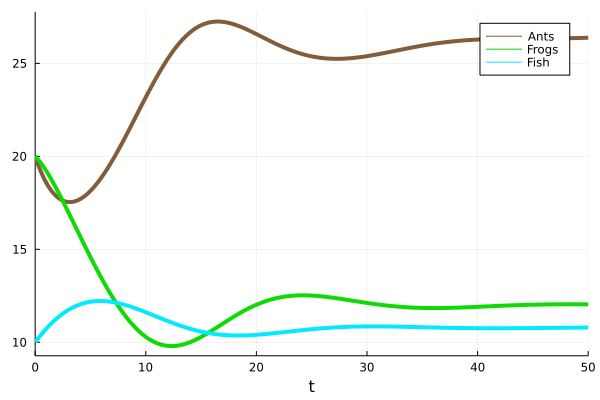

In [12]:
@named ode_model = ODESystem(eco_eqs, t, [🐜,🐸,🐬], [α₁,α₂,δ₁,δ₂,δ₃,g₁,g₂,g₃])

u₀ = [20., 20., 10.]
tspan = (0., 50.)

## numeric p [α₁, α₂, δ₁, δ₂, δ₃, g₁, g₂, g₃]
p = (0.2, 0.3, 0.05, 0.09, 0.1, 0.01, 0.05, 0.08)

ds_ode = ODEProblem(ode_model, u₀, tspan, p)
sol = solve(ds_ode, Tsit5())
Plots.plot(sol, lw=4, lc=cc, labels=["Ants" "Frogs" "Fish"])


For definition of a stochastic differential equation (SDE) model: define the noise model, and then define a `SDESystem`, which we can simulate etc. 

In [13]:
## using multiplicative noise
nsig = 0.06
noise_eqs = [nsig*🐜,
             nsig*🐸,
             nsig*🐬]

@named sde_model = SDESystem(ode_model, noise_eqs); 

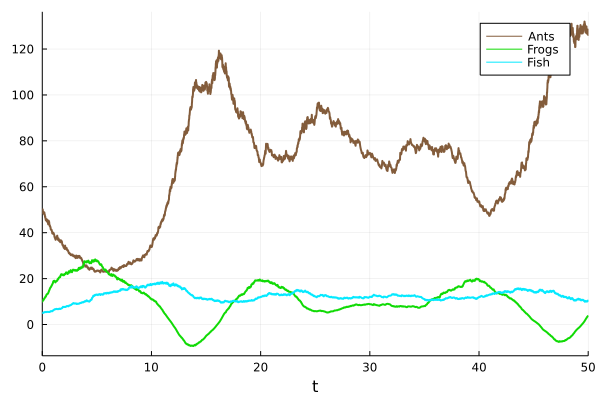

In [14]:
# Define SDE model and simulate
u₀ = [50., 10., 5.]
p = (0.2, 0.3, 0.05, 0.09, 0.1, 0.01, 0.05, 0.08)

ds_sde = SDEProblem(sde_model, u₀, tspan, p) 
sol = solve(ds_sde, SOSRA())
Plots.plot(sol, lw=2, lc=cc, labels=["Ants" "Frogs" "Fish"])


oops! We get negative frogs (sometimes)... we'll deal with that later...
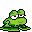

## Model optimization with `MTK`

In `MTK` various operations on models are possible to optimize or simplify them. Demonstrated here on `ecomodel` there is not a great deal to optimize, but as models grow in size or complexity, these tools can be invaluable. Let Julia improve your code for you...

1. Create a symbolic representation from the numeric ODEProblem

In [ ]:
odesys = modelingtoolkitize(ds_ode)


In [ ]:
## Then either run
ds_with_jac = ODEProblem(odesys, u₀, tspan, p, jac=true)


In [ ]:
## Or to output the symbolic Jacobian
generate_jacobian(odesys)[2]


2. Create a simplified representation of your model

In [ ]:
simplified_model = structural_simplify(ode_model) 
equations(simplified_model)


In [ ]:
## Check for correctness 
equations(simplified_model) == equations(ode_model)


## Finding fixed points via nonlinear solve

How about finding the fixed points of your model? For nonlinear systems, this is not yet possible in pure Julia, though can be done via `PyCall` (see last year's [example](https://github.com/adamlmaclean/julia-dynsys-resources/blob/main/Dynsys-ecomodel.ipynb)). However, for numerical approximation of the fixed points, there is a growing [family](https://github.com/JuliaNLSolvers) of optimization/nonlinear solvers in Julia. 


In [15]:
using NonlinearSolve

ss_eqs = [0 ~ α₁*🐜*(1 - g₁*🐜 - g₂*🐸) - α₂*🐜 - δ₁*🐜,
       0 ~ α₂*🐜*(1 - g₃*🐬) - δ₂*🐸,
       0 ~ δ₂*🐸 - δ₃*🐬]

@named ns = NonlinearSystem(ss_eqs, [🐜,🐸,🐬], [α₁,α₂,δ₁,δ₂,δ₃,g₁,g₂,g₃])

guess = [🐜 => 10.0,
         🐸 => 10.0,
         🐬 => 10.0]

params = [α₁ => 2.5,
          α₂ => 0.4, 
          δ₁ => 0.8,
          δ₂ => 2.0,
          δ₃ => 5.0,
          g₁ => 0.01,
          g₂ => 1.0,
          g₃ => 0.1]

np = NonlinearProblem(ns, guess, params)
sol = solve(np, NewtonRaphson())


┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = (::NonlinearSolve.DefaultLinSolve)(x::Vector{Float64}, A::Matrix{Float64}, b::Vector{Float64}, update_matrix::Bool; tol::Nothing, kwargs::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}) at utils.jl:125
└ @ NonlinearSolve /Users/adam/.julia/packages/NonlinearSolve/ZxbEJ/src/utils.jl:125


u: 3-element Vector{Float64}:
 2.5237585102415396
 0.4947624152068414
 0.19790496608273653

## Sensitivity analysis 

In [16]:
## define condition for simulation to end
function condition(u,t,integrator) 
  u[1] < 0.0 || u[2] < 0.0 || u[3] < 0.0
end
floor_event = DiscreteCallback(condition, terminate!)


DiscreteCallback{typeof(condition), typeof(terminate!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}(condition, SciMLBase.terminate!, SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, Bool[1, 1])

In [17]:
@named odeprob = ODESystem(eco_eqs, t, [🐜,🐸,🐬], [α₁,α₂,δ₁,δ₂,δ₃,g₁,g₂,g₃])

u₀ = [20., 20., 10.]
tspan = (0., 50.)
p = (0.2, 0.3, 0.05, 0.09, 0.1, 0.01, 0.05, 0.08)

odeprob = ODEProblem(ode_model, u₀, tspan, p) 


ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 50.0)
u0: 3-element Vector{Float64}:
 20.0
 20.0
 10.0

In [20]:

#odeprob = ODEProblem(ode_model, u₀, tspan, p) 


ens_model = function (p)
    
    dsfun(odeprob,i,repeat) = remake(odeprob; p=p[:,i])
    ds_ensemble = EnsembleProblem(odeprob, prob_func=dsfun)
    sol = solve(ds_ensemble, DynamicSS(Tsit5()), maxiters=10^8, callback=floor_event, reltol=1e-6, isoutofdomain=(u,p,t)->any(x->x<0,u), 
        EnsembleThreads(), trajectories=size(p,2))
    out = zeros(2,size(p,2))
              
    for i in 1:size(p,2)
        out[1,i] = last(sol[i][1,:])
        out[2,i] = maximum(sol[i][1,:])
    end
    out
end

using GlobalSensitivity 


ranges = [[0.,100.],[0.,100.],[0.,100.],[0.,100.],[0.,100.],[0.,100.],[0.,100.]]
Random.seed!(365)

m = gsa(ens_model, Morris(total_num_trajectory=1000,num_trajectory=100), ranges, batch=true)



LoadError: Incompatible problem+solver pairing.
For example, this can occur if an ODE solver is passed with an SDEProblem.
Solvers are only capable of handling specific problem types. Please double
check that the chosen pairing is capable for handling the given problems.

Problem type: ODEProblem
Solver type: DynamicSS
Problem types compatible with the chosen solver: SteadyStateProblem


In [19]:
ranges = [[0.,100.],[0.,100.],[0.,100.],[0.,100.],[0.,100.],[0.,100.],[0.,100.]]
Random.seed!(365)

m = gsa(ens_model, Morris(total_num_trajectory=1000,num_trajectory=100), ranges, batch=true)


LoadError: Incompatible problem+solver pairing.
For example, this can occur if an ODE solver is passed with an SDEProblem.
Solvers are only capable of handling specific problem types. Please double
check that the chosen pairing is capable for handling the given problems.

Problem type: ODEProblem
Solver type: DynamicSS
Problem types compatible with the chosen solver: SteadyStateProblem


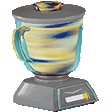
## Blending differential equations and ML 


Now, while some of us have _always_ known that differential equations are 😎, that has not always necessarily been the case for our friends in statistical learning. This has changed. With the realization that mixing differential equations with neural networks can improve both [neural networks](https://arxiv.org/abs/1806.07366) and [diffeq modeling](https://www.sciencedirect.com/science/article/pii/S0021999118307125), a lot of exciting things are happening.

What does this mean for modeling biological systems? Well, all sorts of [interesting](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008462) | [applications](https://royalsocietypublishing.org/doi/10.1098/rspa.2019.0800), and the tantalizing possibilty of being able to learn a model's dynamics and topology concurrently. One approach to do this is via universal differential equations (UDEs; named so after the universal approximation theorem oft inherent in the success of ANNs). The [paper](https://arxiv.org/abs/2001.04385) goes into all the details. Here we'll use UDE modeling in Julia to try to predict the dynamics and learn symbolic terms of our `ecomodel`, using partial knowledge of the trajectories and of the model structure.  

In [ ]:
using DiffEqFlux, Lux, MLUtils
using Optimization, OptimizationOptimJL
using IterTools: ncycle
using Printf

rng = Random.seed!(366)

res_dir = "results"
output_dir = joinpath(pwd(), res_dir)

## Generate data and plot solution
function eco_model!(du, u, p, t)
    α₁, α₂, δ₁, δ₂, δ₃ = p
    du[1] = α₁*u[1] * (1 - 0.01* u[1] - 0.05* u[2]) - δ₁ * u[1]
    du[2] = α₂*u[1]*(1 - 0.08*u[3]) - δ₂*u[2]
    du[3] = δ₂*u[2] - δ₃*u[3]
end

t_span = (0.0, 20.0)
u_0_true = [20.0, 20.0, 10.0]
ode_params = [0.2, 0.3, 0.05, 0.09, 0.1, 0.01, 0.05, 0.08]
num_species = length(u_0_true)
ode_problem = ODEProblem(eco_model!, u_0_true, t_span, ode_params)
ode_solution = solve(ode_problem, Vern7(), abstol=1e-12, reltol=1e-12, saveat=0.1)

Plots.plot(ode_solution)


In [ ]:
## True data
u_true = Array(ode_solution)
t = ode_solution.t
t_size = length(t)

## Generate noisy samples from the solution
sample_size = 10
batch_size = 5
noise_level = 0.01

u_noisy = u_true .+ (noise_level * mean(u_true, dims=2)) .*
                    randn(rng, eltype(u_true), (num_species, t_size, sample_size))
training_data = MLUtils.DataLoader( (u_noisy, ), batchsize=batch_size, shuffle=true, rng=rng)

output_prefix = @sprintf("noise_%.2f", noise_level)
if ode_params[2] == ode_params[3]
    output_prefix *= "_equal_beta_gamma"
end

ode_data_plot = Plots.plot(ode_solution, color=:black, label=["True data" nothing])
for i = 1:sample_size
    Plots.scatter!(t, transpose(u_noisy[:, :, i]), color=:darkred, legend=:none)
end
figure_path = joinpath(output_dir, "$(output_prefix)_data.pdf")
savefig(ode_data_plot, figure_path)



In [ ]:
## Define the network
## Gaussian RBF as activation
rbf(x) = exp.(-(x .^ 2))

U_network = Lux.Chain(
    Lux.Dense(3, 5, rbf), Lux.Dense(5, 5, rbf), Lux.Dense(5, 5, rbf),
    Lux.Dense(5, 3)
)

## Get initial network parameters
nn_params_initial, nn_state = Lux.setup(rng, U_network)

## Define the hybrid model
function ude_dynamics!(du, u, p, t)
    U_pred = U_network(u, p, nn_state)[1]
    du[1] = ode_params[1] * u[1] + U_pred[1]
    du[2] = -ode_params[4] * u[2] + U_pred[2]
end

function ude_predict(θ, u_0; t_begin=t_span[1], t_end=t_span[2])
    ude_problem = ODEProblem(ude_dynamics!, u_0, (t_begin, t_end), θ)
    solve(ude_problem, Vern7(), saveat=0.1, abstol=1e-6, reltol=1e-6,
          sensealg=ForwardDiffSensitivity())
end

num_intervals = 5
subinterval_size = Int((t_size - 1) / num_intervals)
subinterval_bounds = collect(Int, range(1, t_size, length = num_intervals + 1))

function ude_loss(θ, u_batch)
    total_loss = 1e-3 * sum(abs2, θ) ./ length(θ)

    for i = 1:batch_size
        for j = 1:num_intervals
            left = subinterval_bounds[j]
            right = subinterval_bounds[j + 1]
            u_pred = Array(ude_predict(θ, u_batch[:, left, i], t_begin=t[left],
                                       t_end=t[right]))
            total_loss += sum(abs2, u_pred .- u_batch[:, left:right, i])
        end
    end

    total_loss / batch_size
end

function plot_trained_trajectories(θ, figure_path)
    trained_data_plot = plot(ode_solution, color=:black, label=["True data" nothing])
    for i = 1:sample_size
        u_trained = ude_predict(θ, u_noisy[:, 1, i])
        plot!(t, transpose(u_trained), color=:red, label=false)
    end
    savefig(trained_data_plot, figure_path)
end

function training_callback(θ, l)
    push!(training_losses, l)
    num_iters = length(training_losses)

    if num_iters % 100 == 0
        println("Iteration $(num_iters): loss = $(l)")

        figure_path = @sprintf("%s_training_result_iter_%04d.pdf",
                               output_prefix, num_iters)
        figure_path = joinpath(output_dir, figure_path)
        plot_trained_trajectories(θ, figure_path)
    end

    false
end



In [ ]:

## Train UDE
num_epochs = 100
training_losses = []
opt_function = OptimizationFunction(
    (θ, p, u_batch) -> ude_loss(θ, u_batch), Optimization.AutoZygote())
opt_problem = OptimizationProblem(
    opt_function, Lux.ComponentArray(nn_params_initial))
opt_result = Optimization.solve(
    opt_problem, ADAM(0.1), ncycle(training_data, num_epochs),
    callback=training_callback)

nn_params_trained = opt_result.u

println("UDE training finished")

## Plot training loss
training_loss_plot = plot(training_losses, yaxis=:log, label=false)
figure_path = joinpath(output_dir, "$(output_prefix)_training_losses.pdf")
savefig(training_loss_plot, figure_path)

println("Training loss plotted")


In [ ]:
## Symbolic regression on the trained network
using ModelingToolkit, DataDrivenDiffEq

## Using a basis of polynomials up to order 5 
@variables u_sym[1:2]
h_sym = Num[polynomial_basis(u_sym, 5);]
basis_sym = Basis(h_sym, u_sym)
optimizer = STLSQ(Float32.(exp10.(-7:0.1:0)))

for i = 1:5
    sample_idx = Int(sample_size / 5 * i)
    u_trained = ude_predict(nn_params_trained, u_noisy[:, 1, sample_idx])
    sym_reg_problem = ContinuousDataDrivenProblem(Array(u_trained), t)
    sym_reg_result = solve(sym_reg_problem, basis_sym, optimizer,
                           maxiter=10000, progress=true)

    print("Sample $(sample_idx)")
    sym_reg_system = result(sym_reg_result)
    sym_reg_params = parameters(sym_reg_result)
    print(sym_reg_system)
    print(sym_reg_params)

    sym_reg_plot = plot(sym_reg_result)
    figure_path = joinpath(output_dir, "$(output_prefix)_symbolic_regression_$(sample_idx).pdf")
    savefig(sym_reg_plot, figure_path)
end
